# Introduction

This notebook demonstrates the creation of a traditional ML model using the word embeddings provided in the CORA dataset.  It is not possible to optimize the actual embeddings since they were created by the source and the vocabulary is not provided.

We will first establish our connection to the Sandbox DB, where the word vectors are called `features`.  We will pull the features and subjects in and, after some minor data type conversions, create a basic support vector classifier.  After k-folds validation, we will then evaluate the accuracy of this model.

_It is necessary to have the database populated prior to running this notebook._

## Note: This next line is required if you are running this notebook on Google Colab.

In [1]:
!pip install neo4j

     |████████████████████████████████| 76 kB 1.9 MB/s 
  Created wheel for neo4j: filename=neo4j-4.3.7-py3-none-any.whl size=100642 sha256=540731ff1685c75f685e94927b4e099babc2dfdf97baa63e66db35f73b8da9e8
  Stored in directory: /root/.cache/pip/wheels/b5/24/bb/cece9fcfdd5e1aa0683e2533945e1e3f27f70f342ff7e28993
Successfully built neo4j


In [2]:
%matplotlib inline

import ast
import json
import re
import urllib
from pprint import pprint
import time
from tqdm import tqdm

from neo4j import GraphDatabase

import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pprint

In [3]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [4]:
uri = ''
pwd = ''

conn = Neo4jConnection(uri=uri, user="neo4j", pwd=pwd)

conn.query("MATCH (n) RETURN COUNT(n)")

[<Record COUNT(n)=2708>]

In [5]:
def create_df():

    query = """MATCH (p:Paper) RETURN p.id AS id, p.subject AS subject, p.features AS features"""

    df = pd.DataFrame([dict(_) for _ in conn.query(query)])
    df['features'] = df['features'].apply(ast.literal_eval)
    df['embeddings'] = df['features'].apply(lambda x: np.array(x, dtype=float))

    return df


def create_X_y(df):

    X = np.array(df['embeddings'].to_list())
    df['target'] = pd.factorize(df['subject'])[0].astype("float32")
    y = df['target'].to_numpy()

    return X, y

In [6]:
def modeler(k_folds=5, model='linear', show_matrix=True):

    acc_scores = []

    df = create_df()
    X, y = create_X_y(df)

    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        clf = svm.SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        
        
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    if show_matrix:
        matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plt.show(matrix)
        plt.show()
        
    return

Accuracy scores:  [0.7444608567208272, 0.7223042836041359, 0.740029542097489, 0.7001477104874446, 0.7385524372230429]
Mean accuracy:  0.729098966026588


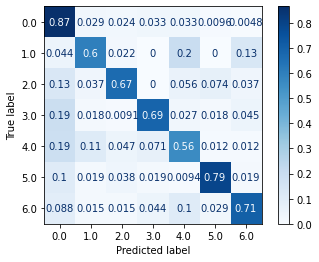

In [7]:
modeler()